## 13. 3.7 Self-consistent schrodnger poisson equation

## Simulation flow
* Self-consistency
  - The electron density is not consistent with the Poisson equation.
  - Better way?
    1) Non-linear Poisson equation(Semi-classical), $\phi(z)$   
    2) Schrodinger equation, $\psi_{z,n}(z)$ and $E_{z,n}$   
    3) Calculation of the electron density, $n(z)$   
    4) Poisson equation, $\phi(z)$ -> feedback to 2)

### Problem
* Repeat L12
* However, in this time, you must get the self-consistent solution.
* Check the covergence behavior.
* Compare the electron densities(the non-self-consistent and self-consistent ones) in the z azis.
  

## self-consistent schrodinger poisson
$$-\frac{\hbar^2}{2m_{zz}}\frac{\partial^2}{\partial^2 z}\psi(z) + V(z)\psi(z)=E_{z,n}\psi(z)\quad (n=1,2,3...) $$
$$V(z)=-q\phi(z)+(E_C-E_i) $$
$$\sum_{i=interface1+1}^{interface2-1}|\psi_{z,n,i}|^2\Delta Z=1 $$
$$n(z)(cm^{-3})=\frac{1}{L_zL_y}\sum_{n=1}^\infty|\psi_{z,n,i}|^2\frac{L_zL_y}{(2\pi)^2}(2\pi)\frac{m_d}{\hbar^2}k_B T ln(1+exp\left(\frac{-E_{z,n}+E_F}{k_B T} \right)) $$
$$n_{total}(z)= 2 \times 2 \times \sum_{valley=1}^3 n(z) $$
위와 같은 schrodinger solver를 구성하고, 풀면 전자 농도가 나오게 되는데, 이 때 나오는 전자 농도를 Poisson solver에 다시 넣게 된다. Poisson solver를 풀게 되면 schrodinger solver의 결과에 따라서 potential이 update가 되고, 이를 다시 schrodinger solver를 푸는데, 사용하는 loop를 형성하게 된다. 이 결과가 어느 정도의 수렴도를 가질 때까지 반복을 한다.   
하지만, 전자 농도를 넣을 때, 다음과 같은 2가지 방식을 시도한다.
$$1. n_{new}=n_{sch}(z) $$
$$2. n_{new,0}=n_{sch}\times e^{\frac{\delta\phi}{V_T}}$$
$$n_{new,n}=n_{new,n-1}\times e^{\frac{\delta\phi}{V_T}}(when\ repeated\ for\ n\ times) $$
1번 방식은 schrodinger solver를 풀어서 나온 전자 농도를 상수로서 poisson solver를 넣는 것이다. 2번 방식은 schrodinger solver를 풀어서 나온 전자 농도를 poisson solver를 풀 때 계속 변하는 값으로 넣게 된다. 이 때 변하는 정도는 위와 같은 수식으로 나타나게 된다.

In [ ]:
% Parameters
q=1.602192e-19; % Elementary charge, C
m0=9.109e-31;  %electron mass, kg
h=6.626176e-34; hbar=h/(2*pi); %Planck constant, J s
k_B=1.38065e-23;     % Boltzmann constant, J/K
T=300;  % Temperature, K
e_si=11.7;  e_ox=3.9;  e0=8.854187817e-12; % Permittivity, F/m
nint=1.075e16; % Intrinsic carrier density, 1/m^3

% Device information
width=5e-9;                % Silicon thickness, m
tox=0.8e-9;           %Oxide thickness
N=67;
dz=(width+2*tox)/(N-1);
interface1=round(tox/dz)+1;  interface2=round((tox+width)/dz)+1;
N1=interface2-interface1-1;  %Silicon part discretization
Na=1e24;          % Doping concentration, 1/m^3
Lx=100e-9; Ly=100e-9;

nmax=N1;  % the number of subbands which are considered.
Jaco=sparse(N,N);
res=zeros(N,1);
coeff=dz*dz*q/e0;
thermal=k_B*T/q;


Electron=zeros(N,1);
Nz=zeros(N,1);

% initial guess
phi=zeros(N,1);
phi(:,1)=0.33374;


% 1. For Simple Poisson Solver


for index_Vg=1:11
    Vg=(index_Vg-1)*0.1; % Gate Voltage
    for Newton=1:40
        Jaco=sparse(N,N);
        res=zeros(N,1);
        for ii=1:N
            if ii==1 || ii==N
                res(ii,1)=phi(ii,1)-0.33374-Vg;
                Jaco(ii,ii)=1;
            elseif  interface1<ii && ii<interface2
                res(ii,1)=e_si*(phi(ii-1,1)-2*phi(ii,1)+phi(ii+1,1))+coeff*(-Na-nint*exp(phi(ii,1)/thermal));
                Jaco(ii,ii+1)=e_si; Jaco(ii,ii)=-2*e_si-coeff*nint*exp(phi(ii,1)/thermal)/thermal;
                Jaco(ii,ii-1)=e_si;
            elseif  ii<interface1 || ii>interface2
                res(ii,1)=e_ox*(phi(ii-1,1)-2*phi(ii,1)+phi(ii+1,1));
                Jaco(ii,ii+1)=e_ox; Jaco(ii,ii)=-2*e_ox; Jaco(ii,ii-1)=e_ox;
            elseif ii==interface1
                res(ii,1)=e_si*(-phi(ii,1)+phi(ii+1,1))-e_ox*(phi(ii,1)-phi(ii-1,1))+coeff*(-Na-nint*exp(phi(ii,1)/thermal))/2;
                Jaco(ii,ii+1)=e_si;
                Jaco(ii,ii)=-e_si-e_ox-coeff*nint*exp(phi(ii,1)/thermal)/(2*thermal);
                Jaco(ii,ii-1)=e_ox;
            elseif ii==interface2
                res(ii,1)=e_ox*(-phi(ii,1)+phi(ii+1,1))-e_si*(phi(ii,1)-phi(ii-1,1))+coeff*(-Na-nint*exp(phi(ii,1)/thermal))/2;
                Jaco(ii,ii+1)=e_ox;
                Jaco(ii,ii)=-e_si-e_ox-coeff*nint*exp(phi(ii,1)/thermal)/(2*thermal);
                Jaco(ii,ii-1)=e_si;
            end
        end
        delphi=Jaco\(-res);
        phi=phi+delphi;
        
        if max(abs(delphi))<1e-15    % Break
            break;
        end
    end
    Elec_save(:,index_Vg)=nint*exp(phi/thermal);
    Electron(interface1:interface2,1)=Elec_save(interface1:interface2,index_Vg); % Electron density, 1/cm^3
    eDensity_Poisson(:,index_Vg)=Electron/1e6;
end




% 2. For Self-Consistent Poisson-Schrodinger Solver

%intital guess
phi=zeros(N,1);
phi(:,1)=0.33374;

for Newton=1:40
    Jaco=sparse(N,N);
    res=zeros(N,1);
    for ii=1:N
        if ii==1 || ii==N
            res(ii,1)=phi(ii,1)-0.33374;
            Jaco(ii,ii)=1;
        elseif  interface1<ii && ii<interface2
            res(ii,1)=e_si*(phi(ii-1,1)-2*phi(ii,1)+phi(ii+1,1))+coeff*(-Na-nint*exp(phi(ii,1)/thermal));
            Jaco(ii,ii+1)=e_si; Jaco(ii,ii)=-2*e_si-coeff*nint*exp(phi(ii,1)/thermal)/thermal;
            Jaco(ii,ii-1)=e_si;
        elseif  ii<interface1 || ii>interface2
            res(ii,1)=e_ox*(phi(ii-1,1)-2*phi(ii,1)+phi(ii+1,1));
            Jaco(ii,ii+1)=e_ox; Jaco(ii,ii)=-2*e_ox; Jaco(ii,ii-1)=e_ox;
        elseif ii==interface1
            res(ii,1)=e_si*(-phi(ii,1)+phi(ii+1,1))-e_ox*(phi(ii,1)-phi(ii-1,1))+coeff*(-Na-nint*exp(phi(ii,1)/thermal))/2;
            Jaco(ii,ii+1)=e_si;
            Jaco(ii,ii)=-e_si-e_ox-coeff*nint*exp(phi(ii,1)/thermal)/(2*thermal);
            Jaco(ii,ii-1)=e_ox;
        elseif ii==interface2
            res(ii,1)=e_ox*(-phi(ii,1)+phi(ii+1,1))-e_si*(phi(ii,1)-phi(ii-1,1))+coeff*(-Na-nint*exp(phi(ii,1)/thermal))/2;
            Jaco(ii,ii+1)=e_ox;
            Jaco(ii,ii)=-e_si-e_ox-coeff*nint*exp(phi(ii,1)/thermal)/(2*thermal);
            Jaco(ii,ii-1)=e_si;
        end
    end
    delphi=Jaco\(-res);
    phi=phi+delphi;
    
    if max(abs(delphi))<1e-15    % Break
        break;
    end
end


for index_Vg=1:11
    Vg=(index_Vg-1)*0.1;
    for Schrodinger=1:50
        Elec_valley=zeros(N1,3);
        ham=zeros(N1,N1);
        
        V=-q*phi+0.56*q;
        
        for valley_type=1:3
            
            if valley_type==1
                mzz=0.91*m0; mxx=0.19*m0; myy=0.19*m0; md=sqrt(mxx*myy);
            elseif valley_type==2
                mzz=0.19*m0; mxx=0.91*m0; myy=0.19*m0; md=sqrt(mxx*myy);
            elseif valley_type==3
                mzz=0.19*m0; mxx=0.19*m0; myy=0.91*m0; md=sqrt(mxx*myy);
            end
            
            for a=1:N1
                if a==1
                    ham(a,a)=-2-2*mzz/(hbar)^2*dz*dz*V(interface1+a,1);
                    ham(a,a+1)=1;
                elseif a==N1
                    ham(a,a)=-2-2*mzz/(hbar)^2*dz*dz*V(interface1+a,1);
                    ham(a,a-1)=1;
                else
                    ham(a,a-1)=1;
                    ham(a,a)=-2-2*mzz/(hbar)^2*dz*dz*V(interface1+a,1);
                    ham(a,a+1)=1;
                end
            end
            [eigenvector,eigenvalue]=eig(ham);
            [Ezn,ind]=sort(diag(eigenvalue)/(-2*mzz*dz*dz)*hbar^2);
            eigenvector_sorted=eigenvector(:,ind);
            normalize=zeros(N1,N1);
            for n=1:N1
                distribution=eigenvector_sorted(:,n).^2;
                Sum=sum(distribution*dz);
                normalize(:,n)=distribution/Sum;
            end
            
            for z=1:N1
                for n=1:nmax
                    subband(n,valley_type)=1*Lx*Ly/(2*pi)*md/(hbar^2)*k_B*T*log(1+exp((-Ezn(n,1))/(k_B*T)));
                    Elec_valley(z,valley_type)=Elec_valley(z,valley_type)+1/(Lx*Ly)*normalize(z,n)*subband(n,valley_type);
                end
            end
        end
        Nz(interface1+1:interface2-1,1)=2*2*sum(Elec_valley,2);
        
        for Newton1=1:30
            jacob=zeros(N,N);
            res=zeros(N,1);
            for ii=1:N
                if ii==1 || ii==N
                    res(ii,1)=phi(ii,1)-0.33374-Vg;
                    jacob(ii,ii)=1;
                elseif  interface1<ii && ii<interface2
                    res(ii,1)=e_si*(phi(ii-1,1)-2*phi(ii,1)+phi(ii+1,1))+coeff*(-Na-Nz(ii,1));
                    jacob(ii,ii+1)=e_si; jacob(ii,ii)=-2*e_si-coeff*Nz(ii,1)/thermal;
                    jacob(ii,ii-1)=e_si;
                elseif  ii<interface1 || ii>interface2
                    res(ii,1)=e_ox*(phi(ii-1,1)-2*phi(ii,1)+phi(ii+1,1));
                    jacob(ii,ii+1)=e_ox; jacob(ii,ii)=-2*e_ox;
                    jacob(ii,ii-1)=e_ox;
                elseif ii==interface1
                    res(ii,1)=e_si*(-phi(ii,1)+phi(ii+1,1))-e_ox*(phi(ii,1)-phi(ii-1,1))+coeff*(-Na-Nz(ii,1))/2;
                    jacob(ii,ii+1)=e_si;
                    jacob(ii,ii)=-e_si-e_ox-coeff*Nz(ii,1)/(2*thermal);
                    jacob(ii,ii-1)=e_ox;
                elseif ii==interface2
                    res(ii,1)=e_ox*(-phi(ii,1)+phi(ii+1,1))-e_si*(phi(ii,1)-phi(ii-1,1))+coeff*(-Na-Nz(ii,1))/2;
                    jacob(ii,ii+1)=e_ox;
                    jacob(ii,ii)=-e_si-e_ox-coeff*Nz(ii,1)/(2*thermal);
                    jacob(ii,ii-1)=e_si;
                end
            end
            update_phi2(:,Newton1)=jacob \ (-res);
            phi=phi+update_phi2(:,Newton1);
            Nz=Nz.*exp(update_phi2(:,Newton1)/thermal);
            
            if max(abs(update_phi2(:,Newton1)))<1e-15
                break;
            end
            
        end
        error(Schrodinger,index_Vg)=max(abs(update_phi2(:,1)));
        
        %   if max(abs(update_phi2(:,1)))<5e-12
        %       break;
        %   end
        
    end
    eDensity_Schrodinger(:,index_Vg)=Nz/1e6;
end


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_10380\2692413049.py:122: RuntimeWarning: overflow encountered in exp
  density = 2*np.sum((psi**2)/((1+np.exp(E/kT))*Lx*Ly),axis=1)


2.9266357115531605e-09
2.118221648084173e-08
5.72969724998984e-07
9.629124461119076e-07
9.335486625960954e-07
9.910847460492533e-07
9.925788213571707e-07
9.5737791050432e-07
9.815973058824312e-07
9.963881484331694e-07
9.655767356786527e-07
[  2.   3.   6.  38.  78. 110. 149. 158. 172. 217. 232.]


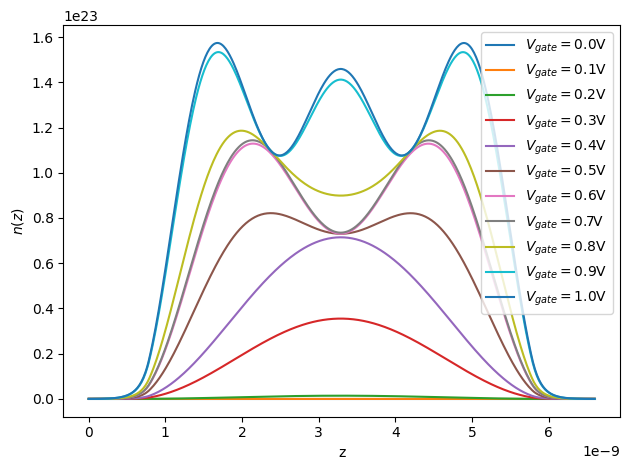

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as sc
import scipy.linalg as slin
import scipy.integrate as inte
import fractions

#np.set_printoptions(formatter={'all':lambda x: str(fractions.Fraction(x).limit_denominator())})

Nc = 2.86*1e+25
#kT = 25.85*1e-3
kT = sc.k*300
ni = Nc*np.exp(-0.56*sc.e/kT)
N = 500
Nacc = 1e+24
q = sc.e 
e1 = 3.9*sc.epsilon_0
e2 = 11.7*sc.epsilon_0
deltax = ((6.6*1e-9)/(N-1))
Lx = 1e-7
Ly = 1e-7
mzz = 0.19*sc.m_e

inter2 = int((N-1)*(5.8/6.6))
inter1 = int((N-1)*(0.8/6.6))
thermal = kT/q

itr = 20 
centerphi = np.zeros(itr)
def density_phi_cl(gate):
    p_density=np.zeros(N)
    e_density=np.zeros(N)
    density=np.zeros(N)
    phi = np.full(N,0.33374)
    #for i in range(itr) :
    GV = (gate)/10.0
    centerphi = 1000
    diff = 1000
    while diff>1e-5 :
        centerphi = phi[int(N/2)]
        e_density = ni*np.exp(q*phi/kT)
        e_density[:inter1] = 0
        e_density[inter2+1:] = 0

        #p_density = ni*np.exp(-q*phi/kT)
        #p_density[:inter1] = 0
        #p_density[inter2+1:] = 0
 
        density = 2*ni*np.sinh(q*phi/kT)
        density[:inter1] = 0
        density[inter2+1:] = 0

        H = np.zeros((N,N))
        np.fill_diagonal(H,-2*e1)
        np.fill_diagonal(H[1:],e1)
        np.fill_diagonal(H[:,1:],e1)

        np.fill_diagonal(H[0:inter2+1],-2*e2)
        np.fill_diagonal(H[1:inter2+1],e2)
        np.fill_diagonal(H[:,1:inter2+1],e2)
        H[inter2][inter2] = (-e2-e1)

        np.fill_diagonal(H[0:inter1+1],-2*e1)
        np.fill_diagonal(H[1:inter1+1],e1)
        np.fill_diagonal(H[:,1:inter1+1],e1)
        H[inter1][inter1] = (-e2-e1)

        H[0][0] = 1
        H[0][1] = 0
        H[N-1][N-1] = 1
        H[N-1][N-2] = 0

        B = np.zeros(N)
        B[inter1] = q*(Nacc+density[inter1])/2.0
        B[inter1+1:inter2] = q*(Nacc+density[inter1+1:inter2])
        B[inter2] = q*(Nacc+density[inter2])/2.0
        B = B*deltax*deltax
        B[0] = 0.33374 + GV
        B[N-1] = 0.33374 + GV

        res = np.zeros(N)
        res = np.matmul(H,phi) - B

        der_B = np.zeros((N,N))
        np.fill_diagonal(der_B[inter1:inter2,inter1:inter2],2*q*(q/kT)*ni*np.cosh(q*phi[inter1:inter2]/kT))
        der_B[inter1,inter1] = (q/kT)*q*ni*np.cosh(q*phi[inter1]/kT)
        der_B[inter2,inter2] = (q/kT)*q*ni*np.cosh(q*phi[inter2]/kT)

        der_B = der_B*deltax*deltax

        Jaco = np.zeros((N,N))
        Jaco = H - der_B
        
        phi=phi + slin.solve(Jaco,-res)

        diff = abs(phi[int(N/2)]-centerphi)
        
    x = np.linspace(0,6.6*1e-9,num=N,endpoint=True)
    #plt.plot(x, density,label=r'$V_{gate}=$'+str(GV)+'V',c=plt.cm.cool(gate/11),marker='o',lw=0,ms=10)
    return density,phi

def density_cooking(phi) :
	bandgap_si = 1.11
	bandgap_o = 8.9

	H = np.zeros((N-2,N-2))
	np.fill_diagonal(H,sc.hbar*sc.hbar/(mzz*deltax*deltax)-q*phi+q*bandgap_o/2.0)
	np.fill_diagonal(H[:inter2-1],sc.hbar*sc.hbar/(mzz*deltax*deltax)-q*phi+q*bandgap_si/2.0)
	np.fill_diagonal(H[:inter1-1],sc.hbar*sc.hbar/(mzz*deltax*deltax)-q*phi+q*bandgap_o/2.0)
	np.fill_diagonal(H[1:],-sc.hbar*sc.hbar/(2*mzz*deltax*deltax))
	np.fill_diagonal(H[:,1:],-sc.hbar*sc.hbar/(2*mzz*deltax*deltax))

	E,psi = slin.eigh(H)
	psi = psi/np.sqrt(deltax)
	psi = np.concatenate((np.zeros((1,N-2)),psi),axis=0)
	psi = np.concatenate((psi,np.zeros((1,N-2))),axis=0)

	#intagrating ground state -> should be 1.
	z = np.linspace(0,6.6*1e-9,N,endpoint=True)
	#print(inte.simps(psi[:,0]**2,x=z))

	density = 2*np.sum((psi**2)/((1+np.exp(E/kT))*Lx*Ly),axis=1)
	return density

def density_phi_qm(gate,density,phi,iters):
    GV = (gate)/10.0
    diff = 1000
    centerphi = 1000
    while diff>1e-6:
        centerphi = phi[int(N/2)]
        H = np.zeros((N,N))
        np.fill_diagonal(H,-2*e1)
        np.fill_diagonal(H[1:],e1)
        np.fill_diagonal(H[:,1:],e1)

        np.fill_diagonal(H[0:inter2+1],-2*e2)
        np.fill_diagonal(H[1:inter2+1],e2)
        np.fill_diagonal(H[:,1:inter2+1],e2)
        H[inter2][inter2] = (-e2-e1)

        np.fill_diagonal(H[0:inter1+1],-2*e1)
        np.fill_diagonal(H[1:inter1+1],e1)
        np.fill_diagonal(H[:,1:inter1+1],e1)
        H[inter1][inter1] = (-e2-e1)

        H[0][0] = 1
        H[0][1] = 0
        H[N-1][N-1] = 1
        H[N-1][N-2] = 0

        B = np.zeros(N)
        dB = np.zeros(N)
        B[inter1] = q*(Nacc+density[inter1])/2.0
        B[inter1+1:inter2] = q*(Nacc+density[inter1+1:inter2])
        B[inter2] = q*(Nacc+density[inter2])/2.0
        dB[inter1] = q*q*(density[inter1])/(2.0*kT)
        dB[inter1+1:inter2] = q*q*(density[inter1+1:inter2])/kT
        dB[inter2] = q*q*(density[inter2])/(2.0*kT)
        B = B*deltax*deltax
        dB = dB*deltax*deltax
        B[0] = 0.33374 + GV
        B[N-1] = 0.33374 + GV
        #phi = slin.solve(H,B)
        residue = np.matmul(H,phi) - B
        Jaco = H - dB
        phi = phi + slin.solve(Jaco,-residue)
        diff = abs(phi[int(N/2)]-centerphi)
        if(diff<1e-6) : print(diff)
        density = density_cooking(phi)
        iters[gate] = iters[gate] + 1
        
    x = np.linspace(0,6.6*1e-9,num=N,endpoint=True)
    plt.plot(x, density,label=r'$V_{gate}=$'+str(GV)+'V')
    return density,phi

iters = np.zeros(11)
for gate in range(11) :
    density, phi = density_phi_cl(gate)
    q_density = density_cooking(phi)
    q_density, phi = density_phi_qm(gate,q_density,phi,iters)

    plt.xlabel("z")
    plt.ylabel(r"$n(z)$")
    plt.legend()
    #plt.yscale('symlog')
    #plt.tick_params(labelsize=18)
    plt.tight_layout()
    
print(iters)
plt.show()



<>:219: SyntaxWarning: invalid escape sequence '\V'
<>:249: SyntaxWarning: invalid escape sequence '\V'
<>:253: SyntaxWarning: invalid escape sequence '\V'
<>:219: SyntaxWarning: invalid escape sequence '\V'
<>:249: SyntaxWarning: invalid escape sequence '\V'
<>:253: SyntaxWarning: invalid escape sequence '\V'
C:\Users\ppjm7\AppData\Local\Temp\ipykernel_10380\758440811.py:219: SyntaxWarning: invalid escape sequence '\V'
  axs[1].set_ylabel('$\Vert \delta\phi \Vert_\mathrm{F}$',fontsize=18)
C:\Users\ppjm7\AppData\Local\Temp\ipykernel_10380\758440811.py:249: SyntaxWarning: invalid escape sequence '\V'
  axs[1].set_ylabel('$\Vert \delta\phi \Vert_\mathrm{F}$',fontsize=18)
C:\Users\ppjm7\AppData\Local\Temp\ipykernel_10380\758440811.py:253: SyntaxWarning: invalid escape sequence '\V'
  axs[2].set_ylabel('$\Vert \delta\phi \Vert_\mathrm{F}$',fontsize=18)


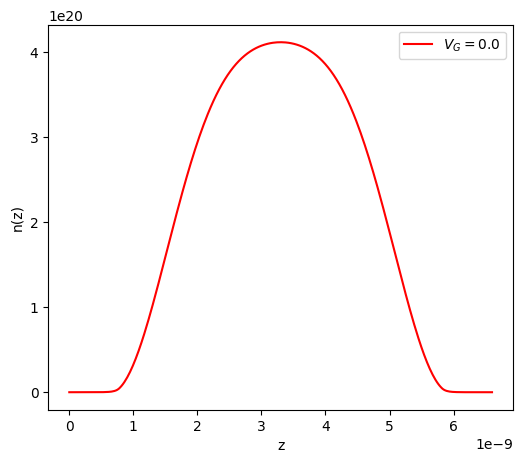

         Vg=0.0         
0.0004855664590640995
2.2539147989830997e-11
         Vg=0.1         
0.021773113534755053
3.958513374042657e-06
8.088918732813857e-12
         Vg=0.2         
0.35248357061043584
0.017201178894044065
7.354449820066445e-05
5.500742460759361e-09
         Vg=0.30000000000000004         
1.078410146797511
0.24461505911042708
0.029794651440130174
0.0004248618773498832
1.462519654884672e-07
2.2449143612636735e-11
         Vg=0.4         
1.8736464654881877
0.6163523794549653
0.10014289801126726
0.003426080611006208
4.592411534114845e-06
6.790365967234558e-10
         Vg=0.5         
2.6874349215334785
1.038489663780143
0.1790535683149723
0.00730624874270816
1.3885054547515498e-05
1.888070016824093e-09
         Vg=0.6000000000000001         
3.5134294455677897
1.4982478682139
0.25083866392189014
0.01154940629231104
2.708397385991527e-05
3.424506560577419e-09
         Vg=0.7000000000000001         
4.348285111994134
1.936697296561026
0.36199875080227567
0.019687700401

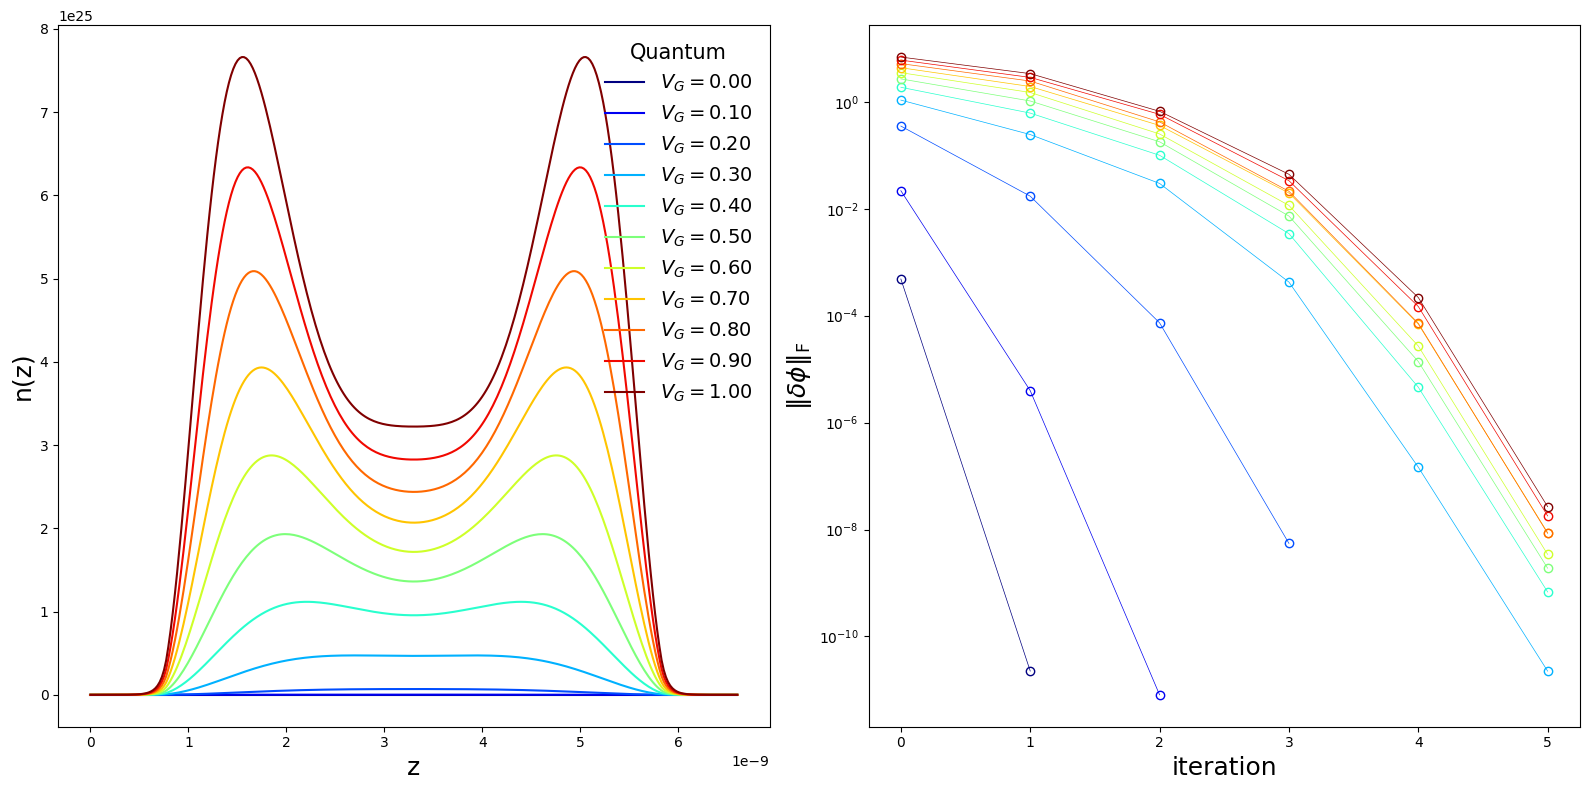

         Vg=0.0         
0.00048556645978620053
2.260559188959262e-11
6.885718338165503e-08
         Vg=0.02         
0.0010507325091942562
3.463952841758527e-10
3.22630462170657e-07
3.2273213622045456e-07
1.012114993029743e-10
         Vg=0.04         
0.0022691898112009953
4.029878521496907e-09
1.506973387374443e-06
1.5079982749155559e-06
1.0245192370301691e-09
         Vg=0.06         
0.004879826172819986
4.258311995091814e-08
6.9921395027721416e-06
7.002424293057368e-06
1.0300330068808398e-08
         Vg=0.08         
0.010400894974504185
4.2433255377790043e-07
1.1479910931621786e-13
3.1991518433006085e-05
3.2093285270672806e-05
1.0208975729690567e-07
3.248417183703325e-10
         Vg=0.1         
0.021773113534535333
3.958513227103454e-06
8.665292368096199e-12
0.00014227461565689784
0.00014325088221080082
9.829657908009024e-07
6.745748251547072e-09
         Vg=0.12         
0.044058533877036836
3.327267908676043e-05
1.7006683939469303e-10
0.000599494003513917
0.000608322253897178

C:\Users\ppjm7\AppData\Local\Temp\ipykernel_10380\758440811.py:256: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim(left=0)


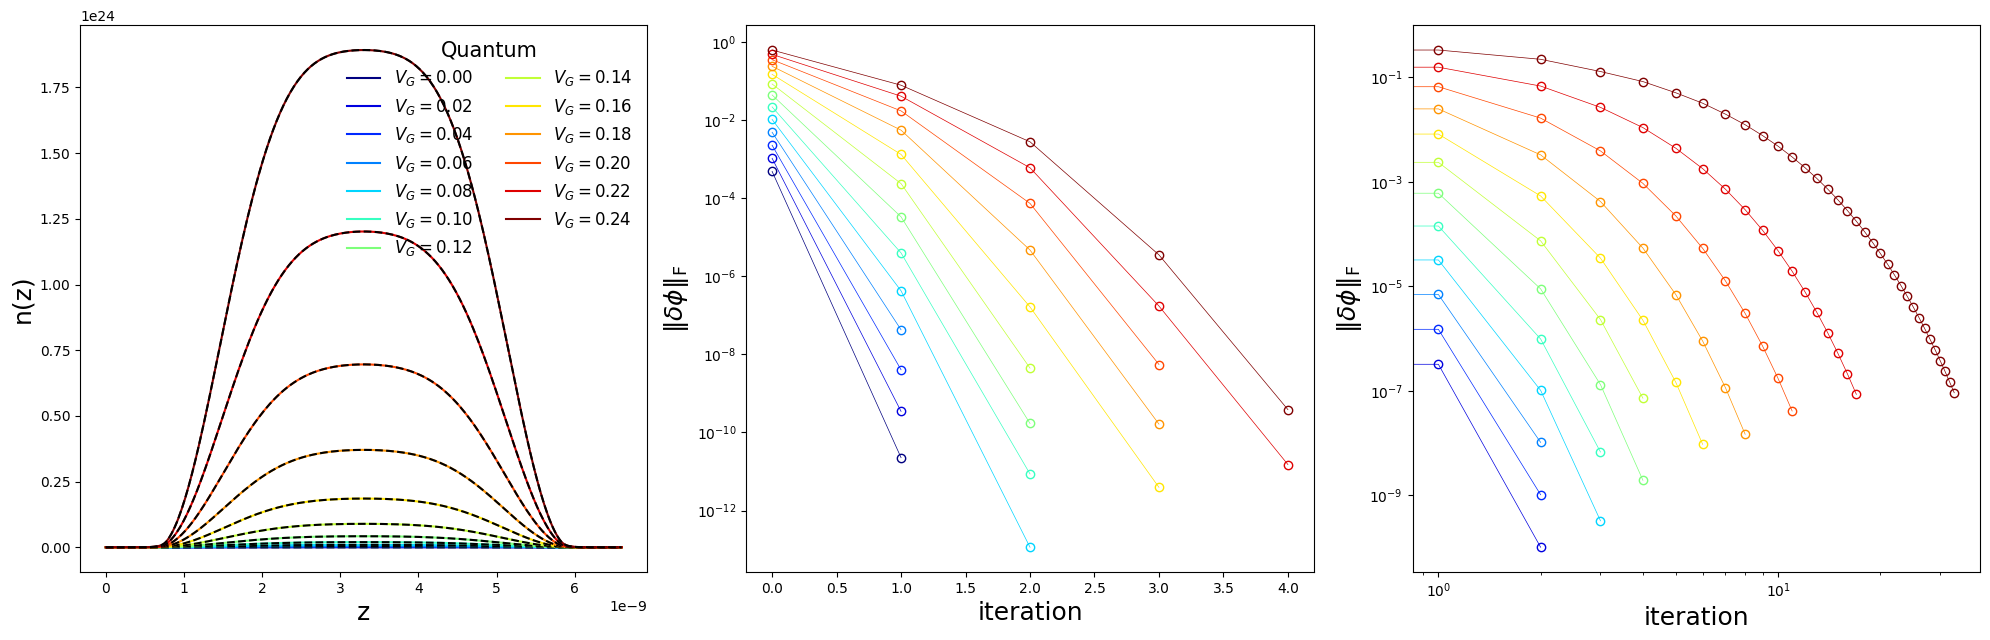

In [10]:
import numpy as np
from scipy.linalg import solve
from scipy.linalg import eigh
from scipy.integrate import simpson
import scipy.constants as const 
import matplotlib.pyplot as plt

N = 300
L = 6.6e-9
h = L/(N-1)
e1 = 3.9*const.epsilon_0
e2 = 11.7*const.epsilon_0
Nacc = 1e24
phi0 = 0.33374
T = 300.
ni = 2.86e25*np.exp(-const.e*0.56/(const.k*T))
M1 = int(N*8./66.)
M2 = int(N*58./66.)

mxx = 0.19*const.m_e
myy = 0.19*const.m_e
mzz = 0.91*const.m_e
Lx = 100e-9
Ly = 100e-9

#####################
#### Poisson eq. ####
#####################

def make_mat():
    H = np.zeros((N,N))

    np.fill_diagonal(H[:M1,:],-2.*e1/h)
    np.fill_diagonal(H[1:M1,:],e1/h)
    np.fill_diagonal(H[:M1,1:],e1/h)

    H[M1,M1] = (-e1-e2)/h; H[M1,M1+1] = e2/h; H[M1,M1-1] = e1/h

    np.fill_diagonal(H[M1+1:,M1+1:],-2.*e2/h)
    np.fill_diagonal(H[M1+1:,M1+2:],e2/h)
    np.fill_diagonal(H[M1+1:,M1:],e2/h)

    H[M2,M2] = (-e2-e1)/h; H[M2,M2+1] = e1/h; H[M2,M2-1] = e2/h

    np.fill_diagonal(H[M2+1:,M2+1:],-2.*e1/h)
    np.fill_diagonal(H[M2+1:,M2+2:],e1/h)
    np.fill_diagonal(H[M2+1:,M2:],e1/h)

    H[0,0] = 1.; H[N-1,N-1] = 1.
    H[0,1] = 0.; H[N-1,N-2] = 0.
    
    return H

def make_b(Vg,phi,n=np.zeros(N),feedback_on=False):
    b = np.zeros(N)

    b[M1+1:M2] = const.e*Nacc*h
    b[M1] = const.e*Nacc*h/2.
    b[M2] = const.e*Nacc*h/2.

    if feedback_on :
        b += const.e*n*h
    else :
        b[M1+1:M2] += 2.*const.e*ni*np.sinh(const.e*phi[M1+1:M2]/(const.k*T))*h
        b[M1] += const.e*ni*np.sinh(const.e*phi[M1]/(const.k*T))*h
        b[M2] += const.e*ni*np.sinh(const.e*phi[M2]/(const.k*T))*h

    b[0] = phi0+Vg; b[N-1] = phi0+Vg

    return b

def make_db(phi):
    db = np.zeros((N,N))

    np.fill_diagonal(db[M1+1:M2,M1+1:M2],2.*const.e*ni*np.cosh(const.e*phi[M1+1:M2]/(const.k*T))*const.e/(const.k*T)*h)
    db[M1,M1] = const.e*ni*np.cosh(const.e*phi[M1]/(const.k*T))*const.e/(const.k*T)*h
    db[M2,M2] = const.e*ni*np.cosh(const.e*phi[M2]/(const.k*T))*const.e/(const.k*T)*h

    return db

def Newton(dx_list,phi_,Vg):
    H = make_mat()

    dx = 1.; phi = phi_
    while dx > 1e-7:
        r = np.matmul(H,phi)-make_b(Vg,phi)
        J = H-make_db(phi)
        dphi = solve(J,-r)
        phi += dphi
        dx = np.linalg.norm(dphi)
        dx_list.append(dx)

    return phi

#########################
#### Schrodinger eq. ####
#########################

def make_mat_Ham():
    H = np.zeros((N-2,N-2))

    np.fill_diagonal(H,-2.)
    np.fill_diagonal(H[1:],1)
    np.fill_diagonal(H[:,1:],1)

    return H/h

def make_db_Ham(phi):
    phi_mat = np.full((N,N),phi)
    dphi_mat = np.diag(np.full(N,0.001))
    pdp_mat = phi_mat+dphi_mat

    n_mat = np.full((N,N),ele_density(phi))
    dn_mat = np.array([ ele_density(pdp_mat[i,:]) for i in range(N) ])

    db = const.e*h*(dn_mat-n_mat).T/np.diag(dphi_mat)

    return db

def FD_dist(E):
    return Lx*Ly/(2.*np.pi*const.hbar**2)*np.sqrt(mxx*myy)*const.k*T*np.log(1.+np.exp(-E/(const.k*T)))

def ele_density(phi):
    gap = np.full(N-2,4.5)
    gap[M1-1:M2] = 0.56

    mzz_list = np.full(N-2,0.58*const.m_e)
    mzz_list[M1-1:M2] = mzz

    Ham = make_mat_Ham()-2.*np.diag(mzz_list)*h/const.hbar**2*const.e*np.diag(gap-phi[1:N-1])
    E,V = eigh(-Ham*const.hbar**2/(2.*mzz*h))

    V = V*np.sqrt(1./h)
    v0 = np.zeros((1,N-2))
    V = np.concatenate((v0,V),axis=0)
    V = np.concatenate((V,v0),axis=0)

    #z = np.linspace(0,L,N)
    #print(simps(V[:,0]**2,z,h)) #print(simps(V[:,0]**2,x=z))

    n_list = np.sum(V**2*FD_dist(E),axis=1)

    return 2.*n_list/(Lx*Ly)

################
#### Solver ####
################

def self_consistency(dx_list,phi_,n_qn,Vg):
    dx = 1.
    while dx>1e-7:
        phi = solve(make_mat(),make_b(Vg,phi_,n_qn,True))
        n_qn = ele_density(phi)
        dphi = phi-phi_; phi_ = phi
        dx = np.linalg.norm(dphi); print(dx)
        dx_list.append(dx)

    return n_qn

def Newton_Ham(dx_list,phi_,n_qn,Vg):
    H = make_mat()
    dx=1.; phi = phi_
    while dx>1e-7:
        r = np.matmul(H,phi)-make_b(Vg,phi,n_qn,True)
        J = H-make_db_Ham(phi)
        dphi = solve(J,-r)
        phi += dphi
        n_qn = ele_density(phi)
        dx = np.linalg.norm(dphi); print(dx)
        dx_list.append(dx)

    return n_qn

phi_ = np.full(N,phi0)
z = np.linspace(0,L,N)

Vg = 0.0
dx_list=[]
phi = Newton(dx_list,phi_,Vg)
n_qn = ele_density(phi)

plt.figure(figsize=(6,5))

plt.xlabel('z')
plt.ylabel('n(z)')
plt.plot(z,n_qn,'r-',label='$V_G=$'+str(Vg))
plt.legend(loc='best')

plt.show()

fig,axs = plt.subplots(1,2,figsize=(16,8))

for Vg in np.linspace(0,1,11):
    print("         Vg="+str(Vg)+"         ")
    
    dx_list=[]
    phi = Newton(dx_list,phi_,Vg)
    n_qn = ele_density(phi)
    #n_cl = np.zeros(N); n_cl[M1:M2+1] =  ni*np.exp(const.e*phi[M1:M2+1]/(const.k*T)) 

    dx_list1 = []
    n_qn1 = Newton_Ham(dx_list1,phi,n_qn,Vg)

    axs[0].plot(z,n_qn1,c=plt.cm.jet(Vg),label='$V_G=$'+str(format(Vg,'1.2f')))
    #axs[1].plot(z,n_cl,c=plt.cm.coolwarm(Vg),label='$V_G=$'+str(format(Vg,'1.2f')))
    axs[1].plot(dx_list1,'.-',ms=12,lw=0.5,mfc='None',c=plt.cm.jet(Vg))

axs[0].set_xlabel('z',fontsize=18)
axs[0].set_ylabel('n(z)',fontsize=18)
legend = axs[0].legend(loc='upper right',ncol=1,fontsize=14,frameon=False)
legend.set_title('Quantum',prop={'size':15})
'''
axs[1].set_xlabel('z',fontsize=18)
axs[1].set_ylabel('n(z)',fontsize=18)
legend = axs[1].legend(loc='best',fontsize=18,frameon=False)
legend.set_title('Semi-classical',prop={'size':18})
'''
axs[1].set_xlabel('iteration',fontsize=18)
axs[1].set_ylabel('$\Vert \delta\phi \Vert_\mathrm{F}$',fontsize=18)
axs[1].set_yscale('log')

fig.tight_layout()
plt.show()

fig,axs = plt.subplots(1,3,figsize=(20,6.5))

for Vg in np.linspace(0,0.24,13):
    print("         Vg="+str(Vg)+"         ")
    
    dx_list=[]
    phi = Newton(dx_list,phi_,Vg)
    n_qn = ele_density(phi)

    dx_list1 = []; dx_list2 = []
    n_qn1 = Newton_Ham(dx_list1,phi,n_qn,Vg)
    n_qn2 = self_consistency(dx_list2,phi,n_qn,Vg)

    axs[0].plot(z,n_qn1,c=plt.cm.jet(Vg/0.24),label='$V_G=$'+str(format(Vg,'1.2f')))
    axs[0].plot(z,n_qn2,'k--')
    axs[1].plot(dx_list1,'.-',ms=12,lw=0.5,mfc='None',c=plt.cm.jet(Vg/0.24))
    axs[2].plot(dx_list2,'.-',ms=12,lw=0.5,mfc='None',c=plt.cm.jet(Vg/0.24))

axs[0].set_xlabel('z',fontsize=18)
axs[0].set_ylabel('n(z)',fontsize=18)
legend = axs[0].legend(loc='upper right',ncol=2,fontsize=12,frameon=False)
legend.set_title('Quantum',prop={'size':15})

axs[1].set_xlabel('iteration',fontsize=18)
axs[1].set_ylabel('$\Vert \delta\phi \Vert_\mathrm{F}$',fontsize=18)
axs[1].set_yscale('log')

axs[2].set_xlabel('iteration',fontsize=18)
axs[2].set_ylabel('$\Vert \delta\phi \Vert_\mathrm{F}$',fontsize=18)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlim(left=0)

fig.tight_layout()
plt.show()



C:\Users\ppjm7\AppData\Local\Temp\ipykernel_10380\1523507545.py:73: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  delphi = spsolve(Jaco.tocsr() + 1e-12*np.eye(N), -res)


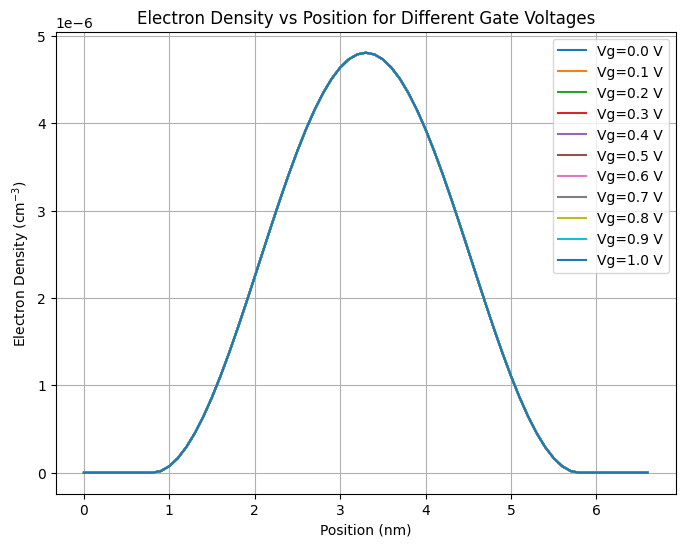

In [27]:
import numpy as np
from scipy.constants import elementary_charge as q, m_e as m0, h, k, epsilon_0 as e0
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import eigh_tridiagonal

# Constants
hbar = h / (2 * np.pi)
T = 300  # Kelvin
k_B = k  # Boltzmann constant
e_si = 11.7
e_ox = 3.9
nint = 1.075e16  # 1/m^3

# Device info
width = 5e-9  # m
tox = 0.8e-9
N = 67
dz = (width + 2 * tox) / (N - 1)
interface1 = int(round(tox / dz))
interface2 = int(round((tox + width) / dz))
N1 = interface2 - interface1 - 1  # Silicon part
Na = 1e24  # Doping, 1/m^3
Lx = 100e-9
Ly = 100e-9

nmax = N1
coeff = dz * dz * q / e0
thermal = k_B * T / q

# Initialize arrays for results
phi = np.full((N, 1), 0.33374)
Electron = np.zeros((N, 1))
Nz = np.zeros((N,1))

eDensity_Poisson = np.zeros((N, 11))
Elec_save = np.zeros((N, 11))

# First Poisson loop
for index_Vg in range(11):
    Vg = index_Vg * 0.1
    phi = np.full((N, 1), 0.33374)
    
    for _ in range(40):  # Newton loop
        Jaco = lil_matrix((N, N))
        res = np.zeros((N, 1))

        for ii in range(N):
            if ii == 0 or ii == N - 1:
                res[ii] = phi[ii] - 0.33374 - Vg
                Jaco[ii, ii] = 1
            elif interface1 < ii < interface2:
                res[ii] = e_si * (phi[ii - 1] - 2 * phi[ii] + phi[ii + 1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal))
                Jaco[ii, ii - 1] = e_si
                Jaco[ii, ii] = -2 * e_si - coeff * nint * np.exp(phi[ii] / thermal) / thermal
                Jaco[ii, ii + 1] = e_si
            elif ii < interface1 or ii > interface2:
                res[ii] = e_ox * (phi[ii - 1] - 2 * phi[ii] + phi[ii + 1])
                Jaco[ii, ii - 1] = e_ox
                Jaco[ii, ii] = -2 * e_ox
                Jaco[ii, ii + 1] = e_ox
            elif ii == interface1:
                res[ii] = e_si * (-phi[ii] + phi[ii + 1]) - e_ox * (phi[ii] - phi[ii - 1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal)) / 2
                Jaco[ii, ii - 1] = e_ox
                Jaco[ii, ii] = -e_si - e_ox - coeff * nint * np.exp(phi[ii] / thermal) / (2 * thermal)
                Jaco[ii, ii + 1] = e_si
            elif ii == interface2:
                res[ii] = e_ox * (-phi[ii] + phi[ii + 1]) - e_si * (phi[ii] - phi[ii - 1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal)) / 2
                Jaco[ii, ii - 1] = e_si
                Jaco[ii, ii] = -e_si - e_ox - coeff * nint * np.exp(phi[ii] / thermal) / (2 * thermal)
                Jaco[ii, ii + 1] = e_ox

        delphi = spsolve(Jaco.tocsr() + 1e-12*np.eye(N), -res)
        phi += delta_phi.reshape(-1, 1)

        if np.max(np.abs(delta_phi)) < 1e-15:
            break

    Elec_save[:, index_Vg] = nint * np.exp(phi[:, 0] / thermal)
    Electron[interface1:interface2, 0] = Elec_save[interface1:interface2, index_Vg]
    eDensity_Poisson[:, index_Vg] = Electron[:, 0] / 1e6

# Schrödinger-Poisson solver setup
max_iter = 100
for index_Vg in range(11):
    Vg = index_Vg * 0.1
    phi = np.full((N, 1), 0.33374)

    for loop in range(max_iter):
        # Schrödinger equation setup
        potential = phi[interface1+1:interface2, 0] * q  # Convert to potential energy
        effective_mass = 0.19 * m0  # Silicon effective mass
        coeff_sch = hbar**2 / (2 * effective_mass * dz**2)

        # Build Hamiltonian (tridiagonal)
        main_diag = potential + 2 * coeff_sch
        off_diag = -coeff_sch * np.ones(N1 - 1)

        eigenvals, eigenvecs = eigh_tridiagonal(main_diag, off_diag)

        # Electron density calculation
        n_subbands = 10
        Electron.fill(0)
        for k in range(n_subbands):
            energy = eigenvals[k]
            wavefunc = eigenvecs[:, k]
            norm = np.sum(wavefunc**2) * dz
            wavefunc /= np.sqrt(norm)

            expo = - (energy - eigenvals[0]) / (k_B * T)
            expo = np.clip(expo, -100,100)
            occ = np.log1p(np.exp(expo))
            #if expo < 100 else expo
            density = (k_B * T * m0) / (np.pi * hbar**2) * occ
            temp_density = density * wavefunc**2

            Electron[interface1+1:interface2, 0] += temp_density

        Electron[:, 0] *= q / 1e6  # Convert from 1/m³ to 1/cm³
        Nz[:, 0] = -Na - Electron[:, 0] / q

        #print("Max Nz:", np.max(Nz[:, 0]))
        #print("Min Nz:", np.min(Nz[:, 0]))
        #print("Nz at interface1:", Nz[interface1, 0])
        #print("Nz at interface2:", Nz[interface2, 0])

        
        # Poisson update
        res = np.zeros((N, 1))
        Jaco = lil_matrix((N, N))

        for ii in range(N):
            if ii == 0 or ii == N - 1:
                res[ii] = phi[ii] - 0.33374 - Vg
                Jaco[ii, ii] = 1
            elif interface1 < ii < interface2:
                res[ii] = e_si * (phi[ii - 1] - 2 * phi[ii] + phi[ii + 1]) + coeff * Nz[ii]
                Jaco[ii, ii - 1] = e_si
                Jaco[ii, ii] = -2 * e_si
                Jaco[ii, ii + 1] = e_si
            elif ii < interface1 or ii > interface2:
                res[ii] = e_ox * (phi[ii - 1] - 2 * phi[ii] + phi[ii + 1])
                Jaco[ii, ii - 1] = e_ox
                Jaco[ii, ii] = -2 * e_ox
                Jaco[ii, ii + 1] = e_ox
            elif ii == interface1:
                res[ii] = e_si * (-phi[ii] + phi[ii + 1]) - e_ox * (phi[ii] - phi[ii - 1]) + coeff * Nz[ii] / 2
                Jaco[ii, ii - 1] = e_ox
                Jaco[ii, ii] = -e_si - e_ox
                Jaco[ii, ii + 1] = e_si
            elif ii == interface2:
                res[ii] = e_ox * (-phi[ii] + phi[ii + 1]) - e_si * (phi[ii] - phi[ii - 1]) + coeff * Nz[ii] / 2
                Jaco[ii, ii - 1] = e_si
                Jaco[ii, ii] = -e_si - e_ox
                Jaco[ii, ii + 1] = e_ox

        update_phi = spsolve(Jaco.tocsr(), -res)
        phi += update_phi.reshape(-1, 1)

        if np.max(np.abs(update_phi)) < 1e-5:
            break

# Variables for third part
update_phi2 = np.zeros((N, 30))
error = np.zeros((50, 11))
eDensity_Schrodinger = np.zeros((N, 11))

for index_Vg in range(11):
    Vg = index_Vg * 0.1
    for Schrodinger in range(50):
        Elec_valley = np.zeros((N1, 3))
        V = -q * phi + 0.56 * q

        for valley_type in range(1, 4):
            if valley_type == 1:
                mzz = 0.91 * m0
                mxx = 0.19 * m0
                myy = 0.19 * m0
            elif valley_type == 2:
                mzz = 0.19 * m0
                mxx = 0.91 * m0
                myy = 0.19 * m0
            elif valley_type == 3:
                mzz = 0.19 * m0
                mxx = 0.19 * m0
                myy = 0.91 * m0

            md = np.sqrt(mxx * myy)
            ham = np.zeros((N1, N1))

            for a in range(N1):
                if a == 0:
                    ham[a, a] = -2 - 2 * mzz * dz**2 / hbar**2 * V[interface1 + a, 0]
                    ham[a, a + 1] = 1
                elif a == N1 - 1:
                    ham[a, a] = -2 - 2 * mzz * dz**2 / hbar**2 * V[interface1 + a, 0]
                    ham[a, a - 1] = 1
                else:
                    ham[a, a] = -2 - 2 * mzz * dz**2 / hbar**2 * V[interface1 + a, 0]
                    ham[a, a + 1] = 1
                    ham[a, a - 1] = 1

            eigenvalue, eigenvector = np.linalg.eigh(ham)
            Ezn = np.sort(eigenvalue * hbar**2 / (-2 * mzz * dz**2))
            ind = np.argsort(eigenvalue)

            # Calculate electron density
            nsub = 10
            density = np.zeros((N1, nsub))
            for k in range(nsub):
                En = Ezn[k]
                psi = eigenvector[:, ind[k]]
                norm = np.sum(psi**2) * dz
                psi = psi / np.sqrt(norm)

                dE = En - Ezn[0]
                exp_factor = np.exp(-dE / (k_B * T))
                DOS = md * k_B * T / (np.pi * hbar**2)
                density[:, k] = DOS * exp_factor * psi**2

            Elec_valley[:, valley_type - 1] = np.sum(density, axis=1) * (q / 1e6)  # unit conversion

        Nz[interface1 + 1:interface2, 0] = 2 * 2 * np.sum(Elec_valley, axis=1) - Na

        # Poisson update
        res = np.zeros((N, 1))
        jacob = lil_matrix((N, N))

        for ii in range(N):
            if ii == 0 or ii == N - 1:
                res[ii] = phi[ii] - 0.33374 - Vg
                jacob[ii, ii] = 1
            elif interface1 < ii < interface2:
                res[ii] = e_si * (phi[ii - 1] - 2 * phi[ii] + phi[ii + 1]) + coeff * Nz[ii]
                jacob[ii, ii - 1] = e_si
                jacob[ii, ii] = -2 * e_si
                jacob[ii, ii + 1] = e_si
            elif ii < interface1 or ii > interface2:
                res[ii] = e_ox * (phi[ii - 1] - 2 * phi[ii] + phi[ii + 1])
                jacob[ii, ii - 1] = e_ox
                jacob[ii, ii] = -2 * e_ox
                jacob[ii, ii + 1] = e_ox
            elif ii == interface1:
                res[ii] = e_si * (-phi[ii] + phi[ii + 1]) - e_ox * (phi[ii] - phi[ii - 1]) + coeff * Nz[ii] / 2
                jacob[ii, ii - 1] = e_ox
                jacob[ii, ii] = -e_si - e_ox
                jacob[ii, ii + 1] = e_si
            elif ii == interface2:
                res[ii] = e_ox * (-phi[ii] + phi[ii + 1]) - e_si * (phi[ii] - phi[ii - 1]) + coeff * Nz[ii] / 2
                jacob[ii, ii - 1] = e_si
                jacob[ii, ii] = -e_si - e_ox
                jacob[ii, ii + 1] = e_ox

        update_phi2[:, Schrodinger] = spsolve(jacob.tocsr(), -res[:, 0])
        phi += update_phi2[:, Schrodinger].reshape(-1, 1)

        error[Schrodinger, index_Vg] = np.max(np.abs(update_phi2[:, Schrodinger]))

        if error[Schrodinger, index_Vg] < 1e-15:
            break

    eDensity_Schrodinger[:, index_Vg] = Electron[:, 0] / 1e6

import matplotlib.pyplot as plt
import numpy as np

positions = np.linspace(0, (N-1)*dz, N) * 1e9  # position in nm

plt.figure(figsize=(8, 6))
for index_Vg in range(11):
    Vg = index_Vg * 0.1
    plt.plot(positions, eDensity_Schrodinger[:, index_Vg], label=f'Vg={Vg:.1f} V')

plt.xlabel('Position (nm)')
plt.ylabel('Electron Density (cm$^{-3}$)')
plt.title('Electron Density vs Position for Different Gate Voltages')
plt.legend()
plt.grid(True)
plt.show()

